20210607 RNN 수업
--

딥러닝 복습

In [1]:
import pandas as pd
import tensorflow as tf

퍼셉트론 복습

신호전달을 활성함수로 처리한다.

XOR 문제를 선형함수가 아닌 비선형함수로 처리

hidden 노드에서는 y-yhat 에서 y값을 알 수 없다.

오류 역전파는 다항함수일 때 체인룰을 사용한다.

가령 ∂z/∂x = ∂z/∂y*∂y/∂x 가 되는 것이다. (d는 미분을 의미하므로, 여기서는 편미분 기호로 반드시 써야함.)

CNN 복습

- CNN은 OpenCV로 전처리가 중요하다. 영상쪽은 C가 필수!


- MNIST

In [2]:
!nvidia-smi

Mon Jun  7 05:12:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Batch Normalization

Internal Covariate Shift : 네트워크의 학습 도중에 파라미터의 변화로 인한 네트워크 Activation(출력)들의 분포 변화

기존의 여러 연구 결과들은 입력값들이 Whitening된다(zero Mean & Unit Variance)면, 뉴럴넷이 훨씬 빠르게 수렴할 것이라고 말하고 있다.

이러한 방법은 Gradient Descent Step의 효과를 줄이는 결과를 초래

또한 Backpropagation 방법도 복잡함
Mini batch 단위로 다음을 수행.
$BN(x;\gamma,\beta)=\beta+\gamma\dfrac{x-E(x)}
{\sqrt{Var(x)+\epsilon}}$

BN은 학습 속도를 향상시켜주고 Gradient Vanishing 문제도 완화시켜줌.

자세한 내용(https://hcnoh.github.io/2018-11-27-batch-normalization)

Keras 보스턴 집값 예측 활용
--

https://wdprogrammer.tistory.com/30

In [12]:
#boston=tf.keras.datasets.boston_housing.load_data(path="boston_housing.npz", test_split=0.2, seed=113)

In [7]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

데이터 전처리

In [13]:
mean=train_data.mean(axis=0)
train_data -= mean
std=train_data.std(axis=0)
train_data /= std 

test_data -= mean
test_data /=  std

모델 구성

In [20]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

모델 학습 및 검증

In [24]:
import numpy as np
k=4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
all_mae_histories = []
for i in  range(k):
    print("processing fold #", i)
    # 검증 데이터 분리
    val_data  = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]

    # 훈련 데이터 분리
    partial_train_data = np.concatenate([train_data[:i*num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)

    # 모델 학습
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
    
    model.compile('sgd', metrics=[tf.keras.metrics.MeanAbsoluteError()])
    mae_history = history.history['mae']
    #mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


MAE 그래프 그리기

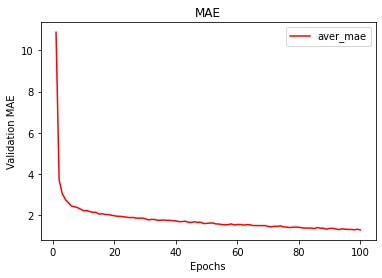

In [27]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history, 'r', label='aver_mae')
plt.title('MAE')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend()
plt.show()

In [28]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [30]:
average_mae_history[:5]

[10.884636640548706,
 3.7119559049606323,
 3.0463160276412964,
 2.761398136615753,
 2.6002659797668457]

폐암 수술환자의 생존율 예측하기 실습
--
https://twinw.tistory.com/248


- activation: 다음 층으로 어떻게 값을 넘길지 결정하는 부분으로, relu, sigmoid 함수 등등이 있다.

- loss: 한 번 신경망이 실행될 때마다 오차 값을 추적하는 함수

- optimizer: 오차를 어떻게 줄여 나갈지 정하는 함수

In [ ]:
from google.colab import files
files.upload()

In [67]:
import pandas as pd
df_cancer=pd.read_csv('ThoraricSurgery.csv')
cancer=numpy.loadtxt('ThoraricSurgery.csv', delimiter=",") # pd.read_csv가 아닌 numpy.loadtxt를 활용

In [78]:
df_cancer=pd.DataFrame(df_cancer)
df_cancer # 18개의 속성을 가지고 있는 것을 알 수 있다.

,293,1,3.8,2.8,0,0.1,0.2,0.3,0.4,0.5,12,0.6,0.7,0.8,1.1,0.9,62,0.10
0,1,2,2.88,2.16,1,0,0,0,1,1,14,0,0,0,1,0,60,0
1,8,2,3.19,2.50,1,0,0,0,1,0,11,0,0,1,1,0,66,1
2,14,2,3.98,3.06,2,0,0,0,1,1,14,0,0,0,1,0,80,1
3,17,2,2.21,1.88,0,0,1,0,0,0,12,0,0,0,1,0,56,0
4,18,2,2.96,1.67,0,0,0,0,0,0,12,0,0,0,1,0,61,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,98,6,3.04,2.40,2,0,0,0,1,0,11,0,0,0,1,0,76,0
465,369,6,3.88,2.72,1,0,0,0,1,0,12,0,0,0,1,0,77,0
466,406,6,5.36,3.96,1,0,0,0,1,0,12,0,0,0,0,0,62,0
467,25,8,4.32,3.20,0,0,0,0,0,0,11,0,0,0,0,0,58,1


In [69]:
cancer

array([[293.  ,   1.  ,   3.8 , ...,   0.  ,  62.  ,   0.  ],
       [  1.  ,   2.  ,   2.88, ...,   0.  ,  60.  ,   0.  ],
       [  8.  ,   2.  ,   3.19, ...,   0.  ,  66.  ,   1.  ],
       ...,
       [406.  ,   6.  ,   5.36, ...,   0.  ,  62.  ,   0.  ],
       [ 25.  ,   8.  ,   4.32, ...,   0.  ,  58.  ,   1.  ],
       [447.  ,   8.  ,   5.2 , ...,   0.  ,  49.  ,   0.  ]])

In [70]:
from keras.models import Sequential # 딥러닝을 여행으로 비유한다면, 케라스는 비행기의 이륙 및 정확한 지점까지의 도착을 책잊미는 파일럿
from keras.layers import Dense

import numpy
import tensorflow as tf # 딥러닝을 여행으로 비유한다면, 텐서플로는 목적지까지 빠르게 이동시켜주는 비행기

seed=0
numpy.random.seed(seed)
tf.random.set_seed(seed)

In [74]:
X=cancer[:, 0:17]
X

array([[293.  ,   1.  ,   3.8 , ...,   1.  ,   0.  ,  62.  ],
       [  1.  ,   2.  ,   2.88, ...,   1.  ,   0.  ,  60.  ],
       [  8.  ,   2.  ,   3.19, ...,   1.  ,   0.  ,  66.  ],
       ...,
       [406.  ,   6.  ,   5.36, ...,   0.  ,   0.  ,  62.  ],
       [ 25.  ,   8.  ,   4.32, ...,   0.  ,   0.  ,  58.  ],
       [447.  ,   8.  ,   5.2 , ...,   0.  ,   0.  ,  49.  ]])

In [75]:
Y=cancer[:,17] # target
Y

array([0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0.

In [73]:
# 딥러닝 모델 구성

model=Sequential() #모델 불러오기
model.add(Dense(30, input_dim=17, activation='relu')) # 모델의 2층 옵션
model.add(Dense(1, activation='sigmoid')) # 모델의 1층 옵션

In [76]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy']) #모델을 실행시키기 위한 조건
model.fit(X,Y, epochs=30, batch_size=10) # 모델 실행

Epoch 1/30
47/47 [==============================] - 1s 2ms/step - loss: 0.6614 - accuracy: 0.3134
Epoch 2/30
47/47 [==============================] - 0s 2ms/step - loss: 0.1549 - accuracy: 0.8449
Epoch 3/30
47/47 [==============================] - 0s 2ms/step - loss: 0.1410 - accuracy: 0.8589
Epoch 4/30
47/47 [==============================] - 0s 2ms/step - loss: 0.1507 - accuracy: 0.8490
Epoch 5/30
47/47 [==============================] - 0s 2ms/step - loss: 0.1643 - accuracy: 0.8356
Epoch 6/30
47/47 [==============================] - 0s 2ms/step - loss: 0.1354 - accuracy: 0.8644
Epoch 7/30
47/47 [==============================] - 0s 2ms/step - loss: 0.1134 - accuracy: 0.8866
Epoch 8/30
47/47 [==============================] - 0s 2ms/step - loss: 0.1652 - accuracy: 0.8344
Epoch 9/30
47/47 [==============================] - 0s 2ms/step - loss: 0.1634 - accuracy: 0.8347
Epoch 10/30
47/47 [==============================] - 0s 2ms/step - loss: 0.1384 - accuracy: 0.8607
Epoch 11/30
47/47 [

In [77]:
# 결과 출력하기
print("\n Accuracy: %.4f" %(model.evaluate(X,Y)[1])) # 딥러닝 모델이 어느 정도 정확하게 예측하는지를 점검

15/15 [==============================] - 0s 3ms/step - loss: 0.1439 - accuracy: 0.8553

 Accuracy: 0.8553


피마 인디언 당뇨병 여부 측정 실습
--

In [ ]:
from google.colab import files
files.upload()

In [92]:
diabetes=pd.read_csv('diabetes.csv')

In [93]:
diavetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


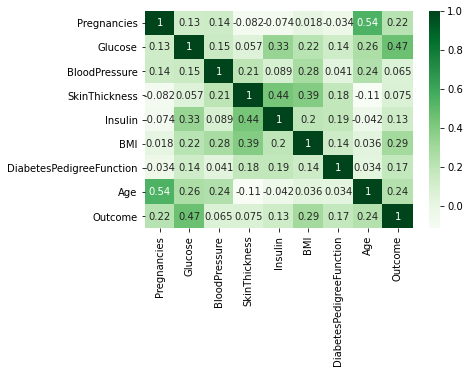

In [96]:
import seaborn as sns

sns.heatmap(diabetes.corr(), cmap='Greens', annot=True)

In [95]:
diabetes.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [105]:
Pre=[float(x) for x in diabetes['Pregnancies']]

In [107]:
diabetes['Pregnancies']=Pre

In [108]:
diabetes['Pregnancies']

0       6.0
1       1.0
2       8.0
3       1.0
4       0.0
       ... 
763    10.0
764     2.0
765     5.0
766     1.0
767     1.0
Name: Pregnancies, Length: 768, dtype: float64

In [111]:
Glu=[float(x) for x in diabetes['Glucose']]
diabetes['Glucose']=Glu

BP=[float(x) for x in diabetes['BloodPressure']]
diabetes['BloodPressure']=BP


ST=[float(x) for x in diabetes['SkinThickness']]
diabetes['SkinThickness']=ST

IS=[float(x) for x in diabetes['Insulin']]
diabetes['Insulin']=IS


Age=[float(x) for x in diabetes['Age']]
diabetes['Age']=Age

In [114]:
Outcome=[float(x) for x in diabetes['Outcome']]
diabetes['Outcome']=Outcome

In [115]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0


In [116]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Outcome                   768 non-null    float64
dtypes: float64(9)
memory usage: 54.1 KB


In [119]:
X=diabetes.drop(['Outcome'], axis=1)
Y=diabetes['Outcome']

In [120]:
seed=0
np.random.seed(seed)
tf.random.set_seed(seed)

In [121]:
model=Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [122]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X,Y, epochs=200, batch_size=10)

In [126]:
print("\n Accuracy: %.4f" %(model.evaluate(X,Y)[1]))

24/24 [==============================] - 0s 2ms/step - loss: 0.4932 - accuracy: 0.7578

 Accuracy: 0.7578


RNN & LSTM
--

LSTM은 gate가 3가지 이다. 


- input gate (입력 게이트)

- forget gate (망각 게이트)

- output gate (출력 게이트)

input gate, forget gate에 시그모이드 함수를 넣어서 output gate로 출력한다.  (RNN은 forget gate가 없다.)